# **Prediction Model**

In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir("/content/drive/My Drive/Colab Notebooks/data2")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

In [4]:
# path for loading data
TRAIN_CSV_PATH = "/content/drive/My Drive/Colab Notebooks/data/train.csv"
TRAIN_NPY_PATH = "/content/drive/My Drive/Colab Notebooks/data/train/"
SAMPLE_SUBMISSION_PATH = "/content/drive/My Drive/Colab Notebooks/data/"

In [5]:
# filenames for the image files
train_file_list = pd.read_csv(TRAIN_CSV_PATH)['file_nm'].values

In [10]:
year_values = pd.read_csv(TRAIN_CSV_PATH)['file_nm'].apply(lambda x: x[0:4] + "-" + x[4:6]).values

## EDA before prediction 

In [11]:
# load and combine all data in the one list
### from other folder ####
all_data = np.load("../data/all_data.npy")

In [12]:
all_data_ice = all_data[:, :, :, 0]

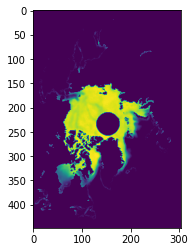

In [13]:
fig = plt.figure()
plt.imshow(all_data_ice[0, :, :])
fig.show()

In [14]:
# sum over all the ice concentration to compare it over time later
data_ice_sum = np.sum(all_data_ice, axis=(1,2))

### Blind spot over time

Each satellite image has a blind spot which is indicated by 1. The area of the blind spot decreases over the years

In [15]:
# blind spot indicated by 1 and 0
all_data[:, :, :, 1][0][230]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
# sum over the blind spots
blind_spot_nums = np.sum(all_data[:, :, :, 1], axis=(1,2))

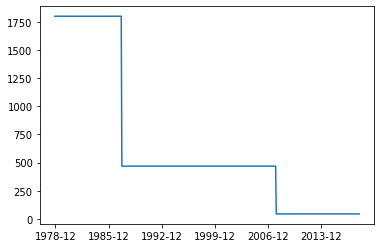

In [28]:
# blind spot getting smaller over some period of years
fig = plt.figure()
plt.plot(blind_spot_nums)
plt.xticks([i for i in range(1, len(year_values), 84)],[year_values[i] for i in range(1, len(year_values), 84)])
fig.show()

In [29]:
fig.savefig("blind_ice.png")

### Average Ice Concentraion value for a pixel over time

Ice Concentration slowly decreases over time. This is not so evident in month to month graph, but when seen in movving average of 60 months(5 years) the change is evident. 

In [30]:
# take out blind spots, and add ice concentrations
measured_pixel_nums = (448 * 304) - blind_spot_nums
average_pixel_value = data_ice_sum / measured_pixel_nums

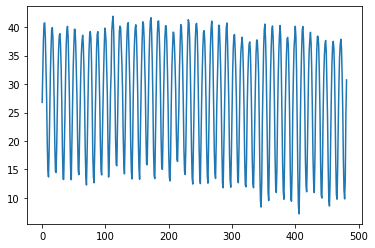

In [31]:
# data is clearly cyclical
fig = plt.figure()
plt.plot(average_pixel_value)
fig.show()

In [32]:
# caculate the moving average
moving_average_60 = pd.Series(average_pixel_value).rolling(window=60).mean()

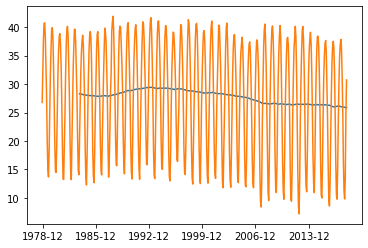

In [34]:
# after adding moving average
# decreasing trend is visible
fig = plt.figure()
plt.plot(moving_average_60)
plt.plot(average_pixel_value)
plt.xticks([i for i in range(1, len(year_values), 84)],[year_values[i] for i in range(1, len(year_values), 84)])
fig.show()

In [35]:
fig.savefig("ice_over_time.png")

In [ ]:
all_data_ice.shape

(482, 448, 304)

### Average ice value for a pixel in different months

When compared over same month over the years, similar decreasing trend is visible

In [ ]:
# add year and month column to group by
train_month_list = pd.read_csv(TRAIN_CSV_PATH)['month'].values
df = pd.DataFrame(data = train_month_list, columns = ["date"])
df["avg_pixel_value"] = average_pixel_value
df["year"] = df['date'].apply(lambda x : int(x[:4]))
df["month"] = df['date'].apply(lambda x : int(x[5:7]))
df

date  avg_pixel_value  year  month
0    1978-11        26.772518  1978     11
1    1978-12        32.718698  1978     12
2    1979-01        37.775264  1979      1
3    1979-02        40.667222  1979      2
4    1979-03        40.769393  1979      3
..       ...              ...   ...    ...
477  2018-08        11.326145  2018      8
478  2018-09         9.796538  2018      9
479  2018-10        13.430921  2018     10
480  2018-11        24.588117  2018     11
481  2018-12        30.732805  2018     12

[482 rows x 4 columns]

In [ ]:
# pivot over the month
df_pivot = df.pivot(index = "year", columns= "month", values="avg_pixel_value")

In [ ]:
# data aligned by same month
df_pivot.head()

month         1          2          3   ...         10         11         12
year                                    ...                                 
1978         NaN        NaN        NaN  ...        NaN  26.772518  32.718698
1979   37.775264  40.667222  40.769393  ...  18.270587  24.722366  31.864837
1980   36.190494  39.586526  39.928940  ...  19.105854  25.801388  32.280454
1981   36.108912  38.475813  38.863497  ...  18.453789  24.557514  31.469972
1982   36.905657  39.473752  40.154018  ...  19.682722  26.878178  32.682030

[5 rows x 12 columns]

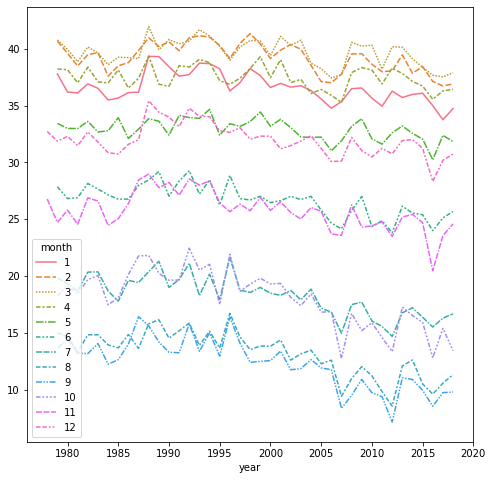

In [ ]:
# decreasing trend is visible
# and ice level goes down and up, as from january to december
fig = plt.figure(figsize=(8, 8))
sns.lineplot(data = df_pivot)
fig.show()

### Produce dataset for training

Use past 5 years data to predict the next years value

In [ ]:
# load the data
encoded_dataset = np.load("encoded_dataset.npy")

In [ ]:
# all loaded
len(encoded_dataset)

482

In [ ]:
# shape check
encoded_dataset.shape

(482, 256)

In [ ]:
# about 40 datasets for each month
encoded_dataset[df["month"] == 1].shape

(40, 256)

In [ ]:
### from other folder ####
# load the original data to make y_train and y_valid dataset
data_ice_filled = np.load("../data/data_iced_filled.npy")

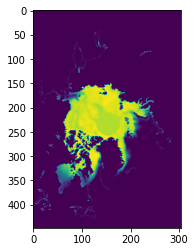

In [ ]:
# data loaded properly
x = data_ice_filled[0]

plt.imshow(x)

In [ ]:
# we will use previous 5 years particular month value to predict the year after
# i.e. to predict 2019 janunary, we use 2018 Jan, 2017 Jan, 2016 Jan, 2015 Jan, 2014 Jan

X_train_full = []
Y_train_encoded_full = []
Y_train_raw_full = []
X_test = []

month_len = np.array([])

for month in range(1, 13, 1):
  encoded_dataset_by_month = encoded_dataset[df["month"] == month]
  data_ice_filled_by_month = data_ice_filled[df["month"] == month]

  data_len = len(encoded_dataset_by_month)
  trainset_len = 0

  X_test += [encoded_dataset_by_month[-5:]]

  for i in range(data_len):
    start = i
    end = i + 5
    if end < data_len:
      trainset_len = i + 1
      X_train_full += [encoded_dataset_by_month[start:end]]
      Y_train_encoded_full += [encoded_dataset_by_month[end]]
      Y_train_raw_full += [data_ice_filled_by_month[end]]


  month_len = np.append(month_len, trainset_len)

In [ ]:
# change each dataset to np array
X_test = np.array(X_test)

In [ ]:
X_train_full = np.array(X_train_full)

In [ ]:
Y_train_encoded_full = np.array(Y_train_encoded_full)

In [ ]:
Y_train_raw_full = np.array(Y_train_raw_full)

In [ ]:
# check data shape, all made properly
print(X_train_full.shape)
print(Y_train_encoded_full.shape)
print(Y_train_raw_full.shape)

(422, 5, 256)
(422, 256)
(422, 448, 304)


In [ ]:
# make indexes to shuffle the dataset
ind_list = np.array([i for i in range(422)])
np.random.shuffle(ind_list)

In [ ]:
# data shuffled
train_shuffled = X_train_full[ind_list]

In [ ]:
# make X_train, X_valid, Y_train, Y_valid dataset
X_train, X_valid = X_train_full[ind_list][:400], X_train_full[ind_list][400:]
Y_train_encoded, Y_valid_encoded = Y_train_encoded_full[ind_list][:400], Y_train_encoded_full[ind_list][400:]
Y_train_raw, Y_valid_raw = Y_train_raw_full[ind_list][:400] / 250, Y_train_raw_full[ind_list][400:] / 250  

In [ ]:
decoder = keras.models.load_model("decoder.h5")

In [ ]:
decoder.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 272384)            70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_14 (Reshape)         (None, 448, 304)          0         
Total params: 70,007,457
Trainable params: 70,007,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# use to plot predictions later on
def plot_predictions(model):
  y_pred = model.predict(X_valid[0:5, :, :])

  fig = plt.figure(figsize=(20, 10))
  for i in range(10):
    fig.add_subplot(2, 5, i+1)
    if i < 5:
      plt.imshow(y_pred[i])
    else:
      plt.imshow(Y_valid_raw[i-5])
  return fig

In [ ]:
decoder.layers[0]._name = 'dense_decoder'

## **Prediction Model**

Prediction Model will have output dimension of (256,) and pass through decoder model with trainable parameters locked. This will ensure image is formed properly, and loss is calculated by the actual image.

Binary Crossentropy is used as loss. All model ran for 100 epochs

Try over variation of model to find the best prediction model
1. One LSTM layer (512 units).  
  **Validation Loss:** 0.0611
2. Two LSTM layers (512 units).  
  **Validation Loss:** 0.0614
3. Three LSTM layers (512 units).  
  **Validation Loss:** 0.0626
4. One LSTM layer with Batch Normalization (512 units).  
  **Validation Loss:** 0.0620
5. Two LSTM layer with Batch Normalization (512 units).  
  **Validation Loss:** 0.0605
6. Bigger LSTM unit with 1 layer (1024 units).  
  **Validation Loss:** 0.0611
7. Bigger LSTM unit with 2 layers (1024 units).  
  **Validation Loss:** 0.0615
8. Smaller LSTM unit with 1 layer (128 units).  
  **Validation Loss:** 0.0616
9. Conv2D before LSTM (2 filters, kernel size: 3, LSTM 512 units).  
  **Validation Loss:** 0.0609
10. Conv2D before 2 LSTM layers(2 filters, kernel size: 3, LSTM 512 units). 
   **Validation Loss:** 0.0622

Choose the model based on Val Loss value, and play around with learning rate and momentum value to find best parameters

### One Layer LSTM

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(512, input_shape=[None, 256]),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 512)               1574912   
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
Total params: 1,706,240
Trainable params: 1,706,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 512)               1574912   
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_decoder (Dense)        (None, 272384)            70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_14 (Reshape)         (None, 448, 304)        

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                metrics=["mse"])

model.fit(X_train, Y_train_raw, epochs=100, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/100
40/40 [==============================] - 2s 27ms/step - loss: 0.1548 - mse: 0.0315 - val_loss: 0.0834 - val_mse: 0.0104
Epoch 2/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0805 - mse: 0.0096 - val_loss: 0.0713 - val_mse: 0.0065
Epoch 3/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0696 - mse: 0.0061 - val_loss: 0.0687 - val_mse: 0.0057
Epoch 4/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0676 - mse: 0.0055 - val_loss: 0.0668 - val_mse: 0.0051
Epoch 5/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0659 - mse: 0.0050 - val_loss: 0.0657 - val_mse: 0.0048
Epoch 6/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0659 - mse: 0.0048 - val_loss: 0.0655 - val_mse: 0.0047
Epoch 7/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0655 - mse: 0.0047 - val_loss: 0.0647 - val_mse: 0.0045
Epoch 8/100
40/40 [==============================] - 1s 15ms/step - loss: 0.

### Two layer LSTM

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(512, return_sequences=True, input_shape=[None, 256]),
    keras.layers.LSTM(512),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 512)         1574912   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
Total params: 3,805,440
Trainable params: 3,805,440
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in range(len(decoder.layers)):

  model.add(decoder.layers[i])
  

In [ ]:
for layer in model.layers[-5:]:
  layer.trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 512)         1574912   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 272384)            70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 448, 304, 1)       1

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                metrics=["mse"])

model.fit(X_train, Y_train_raw, epochs=100, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))



Epoch 1/100
40/40 [==============================] - 36s 38ms/step - loss: 0.1853 - mse: 0.0405 - val_loss: 0.0958 - val_mse: 0.0148
Epoch 2/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0948 - mse: 0.0147 - val_loss: 0.0773 - val_mse: 0.0084
Epoch 3/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0760 - mse: 0.0081 - val_loss: 0.0707 - val_mse: 0.0063
Epoch 4/100
40/40 [==============================] - 1s 16ms/step - loss: 0.0704 - mse: 0.0062 - val_loss: 0.0709 - val_mse: 0.0064
Epoch 5/100
40/40 [==============================] - 1s 16ms/step - loss: 0.0690 - mse: 0.0060 - val_loss: 0.0675 - val_mse: 0.0054
Epoch 6/100
40/40 [==============================] - 1s 16ms/step - loss: 0.0679 - mse: 0.0054 - val_loss: 0.0662 - val_mse: 0.0049
Epoch 7/100
40/40 [==============================] - 1s 16ms/step - loss: 0.0660 - mse: 0.0049 - val_loss: 0.0658 - val_mse: 0.0048
Epoch 8/100
40/40 [==============================] - 1s 16ms/step - loss: 0

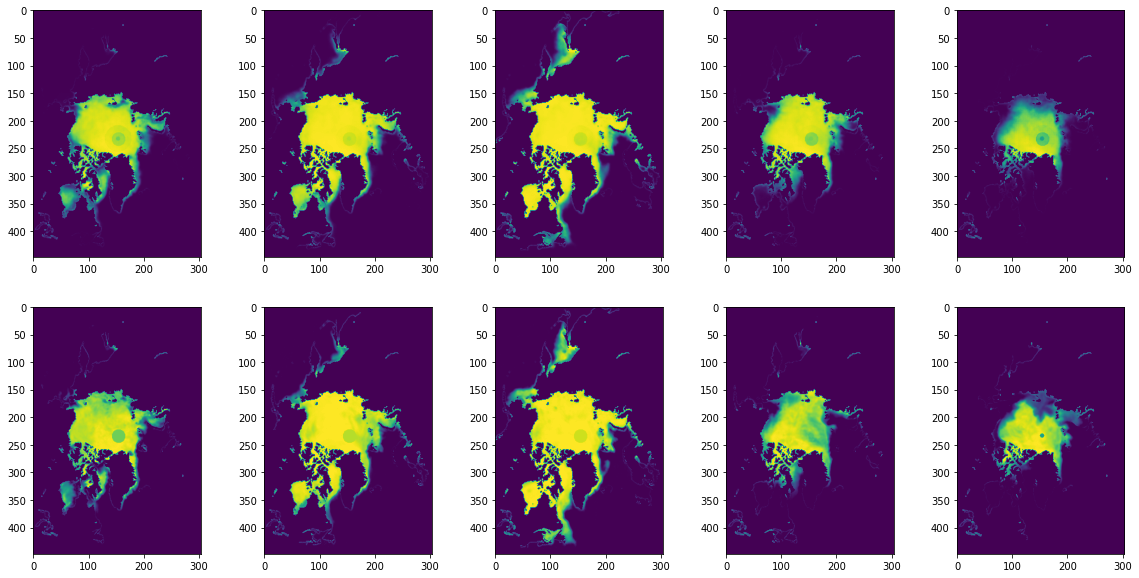

In [ ]:
fig = plot_predictions(model)
fig.show()

### Three Layers LSTM

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(512, return_sequences=True, input_shape=[None, 256]),
    keras.layers.LSTM(512, return_sequences=True),
    keras.layers.LSTM(512),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 512)         2099200   
_________________________________________________________________
lstm_14 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
Total params: 5,904,640
Trainable params: 5,904,640
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 512)         2099200   
_________________________________________________________________
lstm_14 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 272384)            70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 152, 16)     

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                metrics=["mse"])

model.fit(X_train, Y_train_raw, epochs=100, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/100
40/40 [==============================] - 5s 45ms/step - loss: 0.2326 - mse: 0.0528 - val_loss: 0.1028 - val_mse: 0.0170
Epoch 2/100
40/40 [==============================] - 1s 18ms/step - loss: 0.1075 - mse: 0.0188 - val_loss: 0.0954 - val_mse: 0.0147
Epoch 3/100
40/40 [==============================] - 1s 18ms/step - loss: 0.0990 - mse: 0.0158 - val_loss: 0.0838 - val_mse: 0.0106
Epoch 4/100
40/40 [==============================] - 1s 19ms/step - loss: 0.0831 - mse: 0.0105 - val_loss: 0.0748 - val_mse: 0.0077
Epoch 5/100
40/40 [==============================] - 1s 19ms/step - loss: 0.0759 - mse: 0.0079 - val_loss: 0.0738 - val_mse: 0.0074
Epoch 6/100
40/40 [==============================] - 1s 19ms/step - loss: 0.0716 - mse: 0.0067 - val_loss: 0.0698 - val_mse: 0.0060
Epoch 7/100
40/40 [==============================] - 1s 18ms/step - loss: 0.0700 - mse: 0.0059 - val_loss: 0.0686 - val_mse: 0.0057
Epoch 8/100
40/40 [==============================] - 1s 18ms/step - loss: 0.

### With BatchNorm 1 layer

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(512, input_shape=[None, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 512)               1574912   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
Total params: 1,708,288
Trainable params: 1,707,264
Non-trainable params: 1,024
_________________________________________________________________


In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 512)               1574912   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_decoder (Dense)        multiple                  70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 448, 304, 1)     

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                metrics=["mse"])

model.fit(X_train, Y_train_raw, epochs=100, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/100
40/40 [==============================] - 3s 29ms/step - loss: 0.2430 - mse: 0.0500 - val_loss: 0.1516 - val_mse: 0.0340
Epoch 2/100
40/40 [==============================] - 1s 15ms/step - loss: 0.1609 - mse: 0.0289 - val_loss: 0.1088 - val_mse: 0.0179
Epoch 3/100
40/40 [==============================] - 1s 15ms/step - loss: 0.1305 - mse: 0.0208 - val_loss: 0.0892 - val_mse: 0.0119
Epoch 4/100
40/40 [==============================] - 1s 16ms/step - loss: 0.1019 - mse: 0.0139 - val_loss: 0.0893 - val_mse: 0.0112
Epoch 5/100
40/40 [==============================] - 1s 15ms/step - loss: 0.1037 - mse: 0.0148 - val_loss: 0.0835 - val_mse: 0.0096
Epoch 6/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0891 - mse: 0.0112 - val_loss: 0.0796 - val_mse: 0.0090
Epoch 7/100
40/40 [==============================] - 1s 16ms/step - loss: 0.0807 - mse: 0.0089 - val_loss: 0.0764 - val_mse: 0.0080
Epoch 8/100
40/40 [==============================] - 1s 15ms/step - loss: 0.

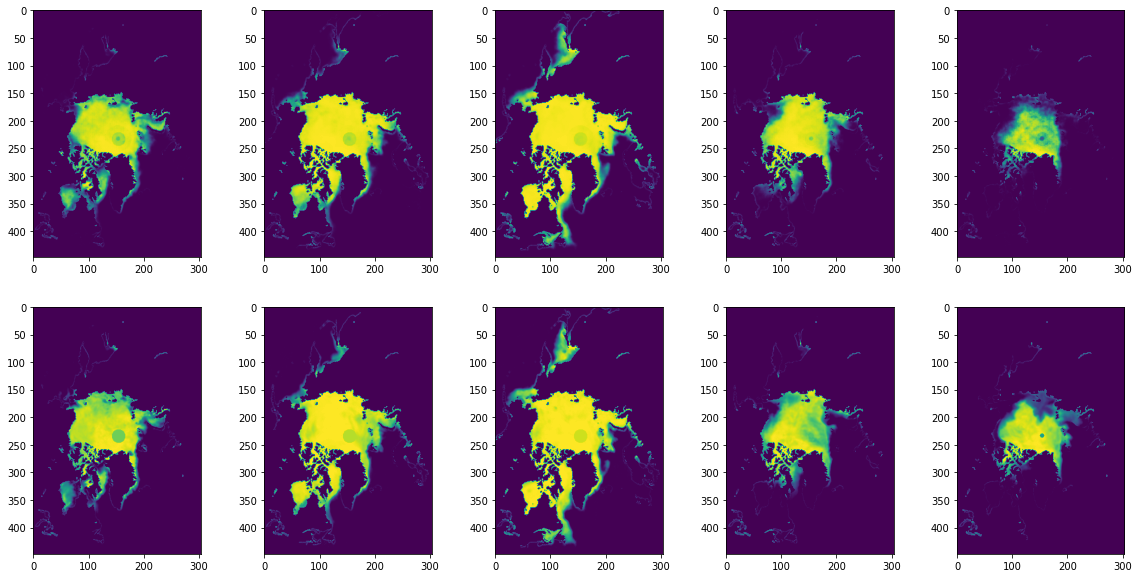

In [ ]:
fig = plot_predictions(model)
fig.show()

### Batch Norm with 2 layers

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(512, return_sequences=True, input_shape=[None, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(512),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 512)         2048      
_________________________________________________________________
lstm_25 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
Total params: 3,809,536
Trainable params: 3,807,488
Non-trainable params: 2,048
_________________________________________________________________


In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 512)         2048      
_________________________________________________________________
lstm_25 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_decoder (Dense)        multiple                  70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)     

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                metrics=["mse"])

model.fit(X_train, Y_train_raw, epochs=100, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/100
40/40 [==============================] - 4s 37ms/step - loss: 0.2160 - mse: 0.0427 - val_loss: 0.1775 - val_mse: 0.0423
Epoch 2/100
40/40 [==============================] - 1s 17ms/step - loss: 0.1514 - mse: 0.0235 - val_loss: 0.1322 - val_mse: 0.0269
Epoch 3/100
40/40 [==============================] - 1s 17ms/step - loss: 0.1195 - mse: 0.0173 - val_loss: 0.1086 - val_mse: 0.0186
Epoch 4/100
40/40 [==============================] - 1s 18ms/step - loss: 0.1096 - mse: 0.0153 - val_loss: 0.0960 - val_mse: 0.0141
Epoch 5/100
40/40 [==============================] - 1s 17ms/step - loss: 0.1054 - mse: 0.0132 - val_loss: 0.0960 - val_mse: 0.0132
Epoch 6/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0970 - mse: 0.0117 - val_loss: 0.0872 - val_mse: 0.0109
Epoch 7/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0882 - mse: 0.0100 - val_loss: 0.0808 - val_mse: 0.0091
Epoch 8/100
40/40 [==============================] - 1s 17ms/step - loss: 0.

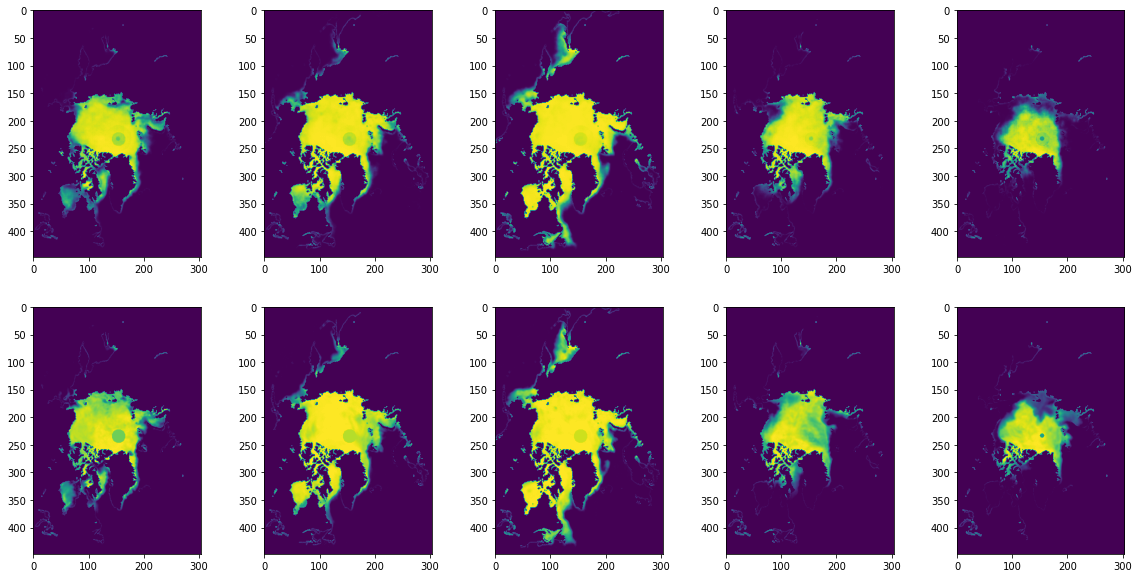

In [ ]:
fig = plot_predictions(model)
fig.show()

### Bigger LSTM Cell

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(1024, input_shape=[None, 256]),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 1024)              5246976   
_________________________________________________________________
dense_15 (Dense)             (None, 256)               262400    
Total params: 5,509,376
Trainable params: 5,509,376
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 1024)              5246976   
_________________________________________________________________
dense_15 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_decoder (Dense)        multiple                  70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_14 (Reshape)         (None, 448, 304)        

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                metrics=["mse"])

model.fit(X_train, Y_train_raw, epochs=100, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/100
40/40 [==============================] - 2s 29ms/step - loss: 0.1437 - mse: 0.0281 - val_loss: 0.0825 - val_mse: 0.0102
Epoch 2/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0802 - mse: 0.0095 - val_loss: 0.0698 - val_mse: 0.0060
Epoch 3/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0688 - mse: 0.0057 - val_loss: 0.0671 - val_mse: 0.0052
Epoch 4/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0668 - mse: 0.0052 - val_loss: 0.0660 - val_mse: 0.0049
Epoch 5/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0659 - mse: 0.0048 - val_loss: 0.0654 - val_mse: 0.0048
Epoch 6/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0647 - mse: 0.0045 - val_loss: 0.0647 - val_mse: 0.0045
Epoch 7/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0643 - mse: 0.0044 - val_loss: 0.0645 - val_mse: 0.0044
Epoch 8/100
40/40 [==============================] - 1s 16ms/step - loss: 0.

### Bigger LSTM cell with 2 layers

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(1024, return_sequences=True, input_shape=[None, 256]),
    keras.layers.LSTM(1024),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 1024)        5246976   
_________________________________________________________________
lstm_11 (LSTM)               (None, 1024)              8392704   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
Total params: 13,902,080
Trainable params: 13,902,080
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 1024)        5246976   
_________________________________________________________________
lstm_11 (LSTM)               (None, 1024)              8392704   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_9 (Dense)              (None, 272384)            70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 448, 304, 1)      

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                metrics=["mse"])

model.fit(X_train, Y_train_raw, epochs=100, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/100
40/40 [==============================] - 4s 41ms/step - loss: 0.1779 - mse: 0.0382 - val_loss: 0.0918 - val_mse: 0.0135
Epoch 2/100
40/40 [==============================] - 1s 22ms/step - loss: 0.0929 - mse: 0.0143 - val_loss: 0.0756 - val_mse: 0.0078
Epoch 3/100
40/40 [==============================] - 1s 22ms/step - loss: 0.0739 - mse: 0.0074 - val_loss: 0.0693 - val_mse: 0.0059
Epoch 4/100
40/40 [==============================] - 1s 22ms/step - loss: 0.0694 - mse: 0.0057 - val_loss: 0.0703 - val_mse: 0.0063
Epoch 5/100
40/40 [==============================] - 1s 22ms/step - loss: 0.0674 - mse: 0.0053 - val_loss: 0.0670 - val_mse: 0.0052
Epoch 6/100
40/40 [==============================] - 1s 22ms/step - loss: 0.0663 - mse: 0.0051 - val_loss: 0.0668 - val_mse: 0.0052
Epoch 7/100
40/40 [==============================] - 1s 22ms/step - loss: 0.0663 - mse: 0.0049 - val_loss: 0.0652 - val_mse: 0.0047
Epoch 8/100
40/40 [==============================] - 1s 22ms/step - loss: 0.

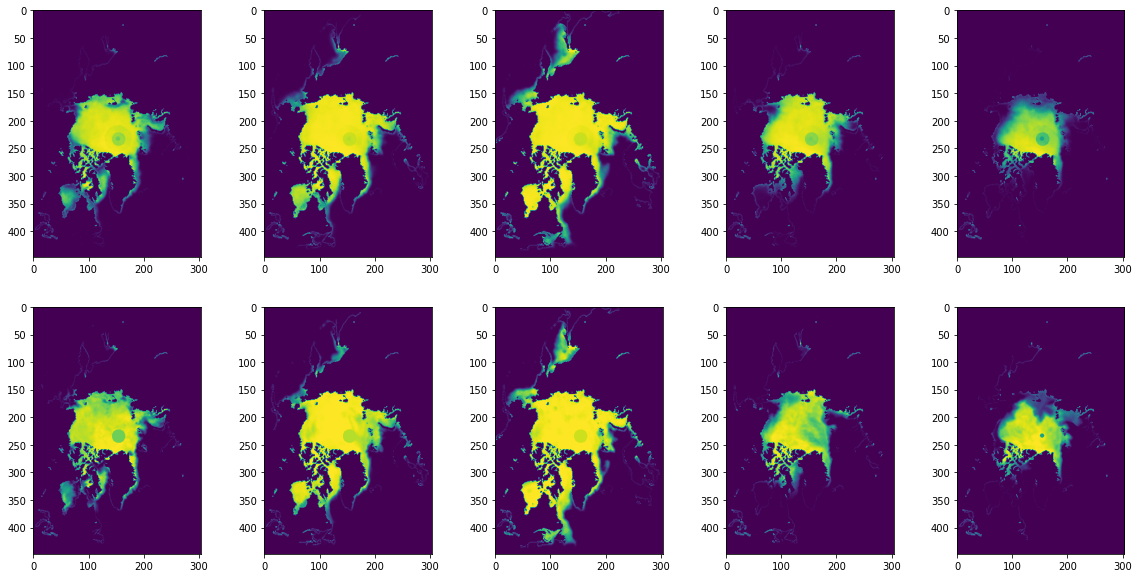

In [ ]:
fig = plot_predictions(model)
fig.show()

### Smaller LSTM with one layer

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(128, input_shape=[None, 256]),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
Total params: 230,144
Trainable params: 230,144
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_decoder (Dense)        multiple                  70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_14 (Reshape)         (None, 448, 304)        

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                metrics=["mse"])

model.fit(X_train, Y_train_raw, epochs=100, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/100
40/40 [==============================] - 2s 26ms/step - loss: 0.1915 - mse: 0.0426 - val_loss: 0.0954 - val_mse: 0.0144
Epoch 2/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0915 - mse: 0.0132 - val_loss: 0.0773 - val_mse: 0.0083
Epoch 3/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0768 - mse: 0.0082 - val_loss: 0.0724 - val_mse: 0.0068
Epoch 4/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0717 - mse: 0.0067 - val_loss: 0.0707 - val_mse: 0.0064
Epoch 5/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0696 - mse: 0.0061 - val_loss: 0.0693 - val_mse: 0.0059
Epoch 6/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0679 - mse: 0.0056 - val_loss: 0.0673 - val_mse: 0.0052
Epoch 7/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0679 - mse: 0.0053 - val_loss: 0.0667 - val_mse: 0.0051
Epoch 8/100
40/40 [==============================] - 1s 14ms/step - loss: 0.

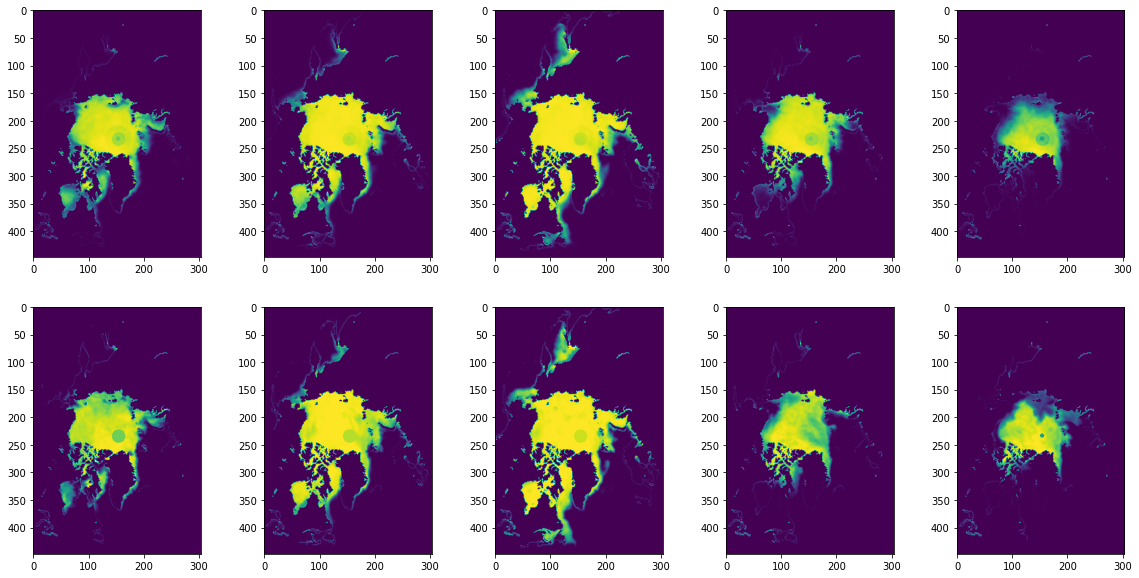

In [ ]:
fig = plot_predictions(model)
fig.show()

### Use Conv2D before LSTM

In [ ]:
model = keras.models.Sequential([
    keras.layers.Reshape([5, 256, 1], input_shape=[5, 256]),
    keras.layers.Conv2D(2, 3, padding="same", activation="relu"),
    keras.layers.Reshape([5, 512]),
    keras.layers.LSTM(512),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 5, 256, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 256, 2)         20        
_________________________________________________________________
reshape_3 (Reshape)          (None, 5, 512)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
Total params: 2,230,548
Trainable params: 2,230,548
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 5, 256, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 256, 2)         20        
_________________________________________________________________
reshape_3 (Reshape)          (None, 5, 512)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_decoder (Dense)        multiple                  70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)     

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                metrics=["mse"])

model.fit(X_train, Y_train_raw, epochs=100, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/100
40/40 [==============================] - 3s 28ms/step - loss: 0.1692 - mse: 0.0354 - val_loss: 0.0887 - val_mse: 0.0125
Epoch 2/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0889 - mse: 0.0127 - val_loss: 0.0809 - val_mse: 0.0096
Epoch 3/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0808 - mse: 0.0095 - val_loss: 0.0713 - val_mse: 0.0067
Epoch 4/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0706 - mse: 0.0064 - val_loss: 0.0683 - val_mse: 0.0056
Epoch 5/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0718 - mse: 0.0067 - val_loss: 0.0659 - val_mse: 0.0048
Epoch 6/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0680 - mse: 0.0055 - val_loss: 0.0649 - val_mse: 0.0046
Epoch 7/100
40/40 [==============================] - 1s 15ms/step - loss: 0.0654 - mse: 0.0047 - val_loss: 0.0652 - val_mse: 0.0047
Epoch 8/100
40/40 [==============================] - 1s 15ms/step - loss: 0.

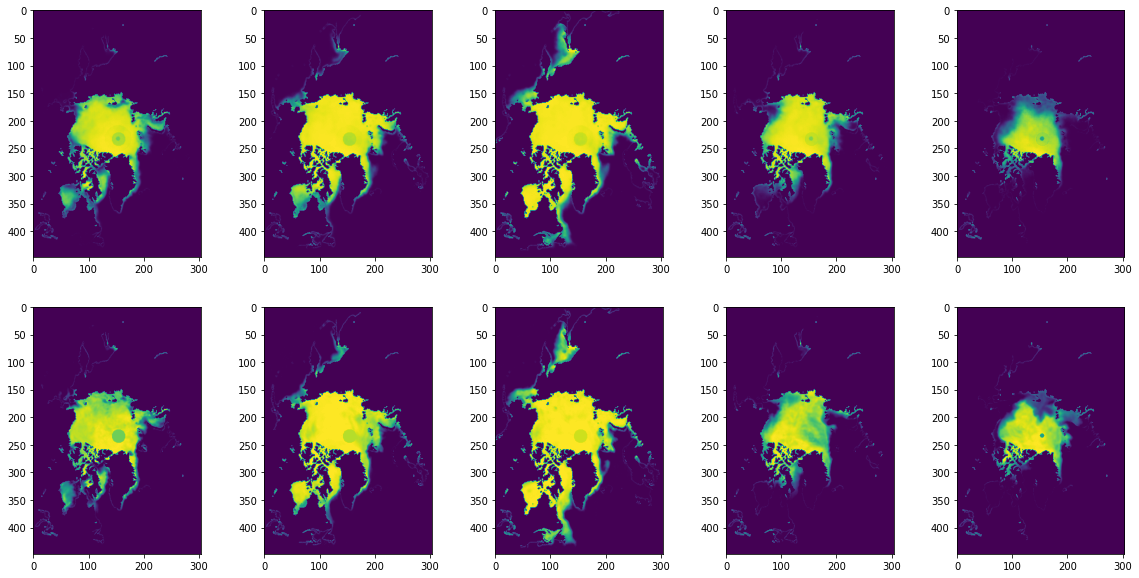

In [ ]:
fig = plot_predictions(model)
fig.show()

### Conv2D and two LSTM layers



In [ ]:
model = keras.models.Sequential([
    keras.layers.Reshape([5, 256, 1], input_shape=[5, 256]),
    keras.layers.Conv2D(2, 3, padding="same", activation="relu"),
    keras.layers.Reshape([5, 512]),
    keras.layers.LSTM(512, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(512),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 5, 256, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 256, 2)         20        
_________________________________________________________________
reshape_5 (Reshape)          (None, 5, 512)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 5, 512)            2099200   
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 512)            2048      
_________________________________________________________________
lstm_31 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)             

In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 5, 256, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 256, 2)         20        
_________________________________________________________________
reshape_5 (Reshape)          (None, 5, 512)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 5, 512)            2099200   
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 512)            2048      
_________________________________________________________________
lstm_31 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)             

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                metrics=["mse"])

model.fit(X_train, Y_train_raw, epochs=100, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/100
40/40 [==============================] - 4s 39ms/step - loss: 0.2266 - mse: 0.0446 - val_loss: 0.2908 - val_mse: 0.0709
Epoch 2/100
40/40 [==============================] - 1s 17ms/step - loss: 0.1614 - mse: 0.0290 - val_loss: 0.2330 - val_mse: 0.0569
Epoch 3/100
40/40 [==============================] - 1s 18ms/step - loss: 0.1271 - mse: 0.0198 - val_loss: 0.1822 - val_mse: 0.0422
Epoch 4/100
40/40 [==============================] - 1s 18ms/step - loss: 0.1159 - mse: 0.0171 - val_loss: 0.1455 - val_mse: 0.0305
Epoch 5/100
40/40 [==============================] - 1s 17ms/step - loss: 0.1055 - mse: 0.0146 - val_loss: 0.1136 - val_mse: 0.0200
Epoch 6/100
40/40 [==============================] - 1s 17ms/step - loss: 0.1069 - mse: 0.0152 - val_loss: 0.0979 - val_mse: 0.0146
Epoch 7/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0874 - mse: 0.0103 - val_loss: 0.0882 - val_mse: 0.0117
Epoch 8/100
40/40 [==============================] - 1s 18ms/step - loss: 0.

### Batchnorm with 2 LSTM layers seem to work the best

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(512, return_sequences=True, input_shape=[None, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(512),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="selu"),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_37 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
Total params: 3,875,328
Trainable params: 3,873,280
Non-trainable params: 2,048
_______________________________________

In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_37 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_decoder (Dense)        multiple                

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                metrics=["mse"])

model.fit(X_train, Y_train_raw, epochs=100, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/100
40/40 [==============================] - 4s 38ms/step - loss: 0.1732 - mse: 0.0330 - val_loss: 0.1792 - val_mse: 0.0428
Epoch 2/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0725 - mse: 0.0068 - val_loss: 0.1726 - val_mse: 0.0405
Epoch 3/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0689 - mse: 0.0058 - val_loss: 0.1503 - val_mse: 0.0332
Epoch 4/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0673 - mse: 0.0052 - val_loss: 0.1406 - val_mse: 0.0308
Epoch 5/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0661 - mse: 0.0049 - val_loss: 0.1243 - val_mse: 0.0249
Epoch 6/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0663 - mse: 0.0049 - val_loss: 0.0967 - val_mse: 0.0156
Epoch 7/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0642 - mse: 0.0042 - val_loss: 0.0833 - val_mse: 0.0111
Epoch 8/100
40/40 [==============================] - 1s 17ms/step - loss: 0.

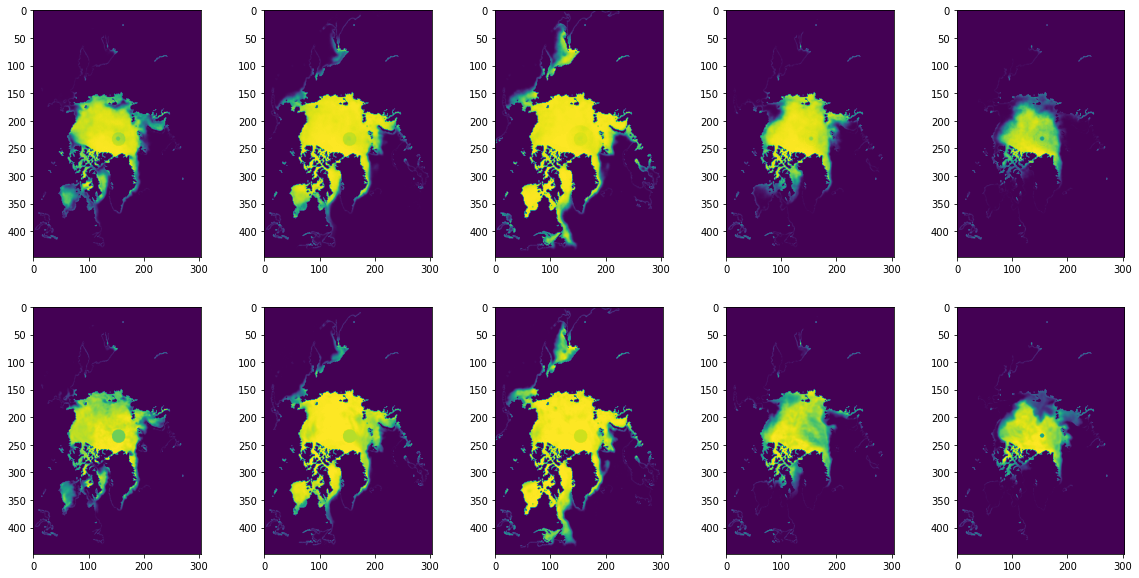

In [ ]:
fig = plot_predictions(model)
fig.show()

### **Hyperparameter tuning**

Hypeparameter Tuning for two LSTM layers with BatchNormalization  
1. Learning rate = 0.1, Momentum = 0.9  
  **Validation Loss after 200 epochs:** 0.0602
2. Learning rate = 0.01, Momentum = 0.99  
  **Validation Loss after 200 epochs:** 0.0610
3. Learning rate = 0.001, Momentum = 0.999  
  **Validation Loss after 400 epochs:** 0.0600
4. Learning rate = 0.001, Momentum = 0.999, l2 regularization  
  **Validation Loss after 400 epochs:** 0.0727
5. Learning rate = 0.001, Momentum = 0.999, with dropout(0.2)  
  **Validation Loss after 400 epochs:** 0.0618
6. Learning rate = 0.001, Momentum = 0.999, with max norm  
  **Validation Loss after 400 epochs:** 0.0610

We will use the Model with learning rate 0.001 and Momentum 0.999

#### lr = 0.1, momentum = 0.9

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(512, return_sequences=True, input_shape=[None, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(512),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="selu"),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_43 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
Total params: 3,875,328
Trainable params: 3,873,280
Non-trainable params: 2,048
_______________________________________

In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_43 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_decoder (Dense)        multiple                

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9),
                metrics=["mse"])

history = model.fit(X_train, Y_train_raw, epochs=200, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/200
40/40 [==============================] - 4s 37ms/step - loss: 0.2206 - mse: 0.0451 - val_loss: 0.1336 - val_mse: 0.0284
Epoch 2/200
40/40 [==============================] - 1s 17ms/step - loss: 0.0761 - mse: 0.0071 - val_loss: 0.1236 - val_mse: 0.0241
Epoch 3/200
40/40 [==============================] - 1s 17ms/step - loss: 0.0702 - mse: 0.0058 - val_loss: 0.1203 - val_mse: 0.0227
Epoch 4/200
40/40 [==============================] - 1s 17ms/step - loss: 0.0691 - mse: 0.0056 - val_loss: 0.1170 - val_mse: 0.0218
Epoch 5/200
40/40 [==============================] - 1s 17ms/step - loss: 0.0669 - mse: 0.0052 - val_loss: 0.1058 - val_mse: 0.0178
Epoch 6/200
40/40 [==============================] - 1s 17ms/step - loss: 0.0669 - mse: 0.0050 - val_loss: 0.0940 - val_mse: 0.0144
Epoch 7/200
40/40 [==============================] - 1s 17ms/step - loss: 0.0654 - mse: 0.0046 - val_loss: 0.0788 - val_mse: 0.0090
Epoch 8/200
40/40 [==============================] - 1s 18ms/step - loss: 0.

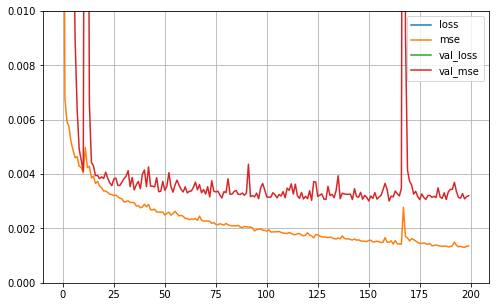

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 0.01)
plt.show()

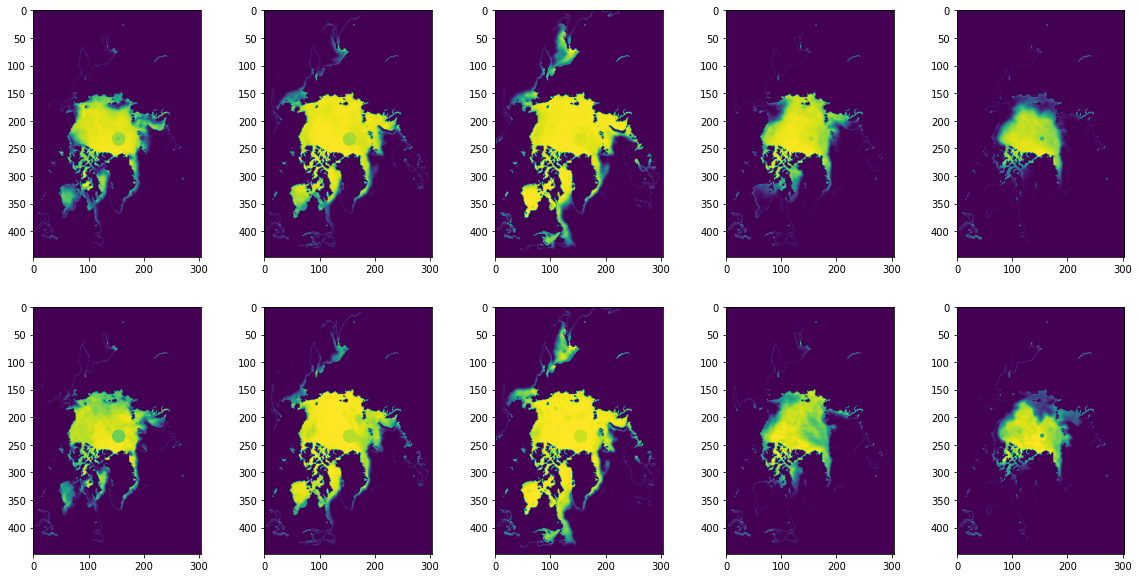

In [ ]:
fig = plot_predictions(model)
fig.show()

#### lr = 0.01, momentum = 0.99

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(512, return_sequences=True, input_shape=[None, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(512),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="selu"),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_20 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_45 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
dense_32 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_33 (Dense)             (None, 256)               65792     
Total params: 3,875,328
Trainable params: 3,873,280
Non-trainable params: 2,048
_______________________________________

In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_20 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_45 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
dense_32 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_33 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_decoder (Dense)        multiple                

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.99),
                metrics=["mse"])

history = model.fit(X_train, Y_train_raw, epochs=200, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/200
40/40 [==============================] - 4s 38ms/step - loss: 0.2940 - mse: 0.0645 - val_loss: 0.2403 - val_mse: 0.0603
Epoch 2/200
40/40 [==============================] - 1s 18ms/step - loss: 0.1462 - mse: 0.0268 - val_loss: 0.1144 - val_mse: 0.0217
Epoch 3/200
40/40 [==============================] - 1s 18ms/step - loss: 0.0845 - mse: 0.0096 - val_loss: 0.0856 - val_mse: 0.0110
Epoch 4/200
40/40 [==============================] - 1s 18ms/step - loss: 0.0845 - mse: 0.0092 - val_loss: 0.0785 - val_mse: 0.0085
Epoch 5/200
40/40 [==============================] - 1s 17ms/step - loss: 0.0761 - mse: 0.0070 - val_loss: 0.0775 - val_mse: 0.0082
Epoch 6/200
40/40 [==============================] - 1s 18ms/step - loss: 0.0745 - mse: 0.0068 - val_loss: 0.0752 - val_mse: 0.0076
Epoch 7/200
40/40 [==============================] - 1s 18ms/step - loss: 0.0733 - mse: 0.0065 - val_loss: 0.0724 - val_mse: 0.0070
Epoch 8/200
40/40 [==============================] - 1s 17ms/step - loss: 0.

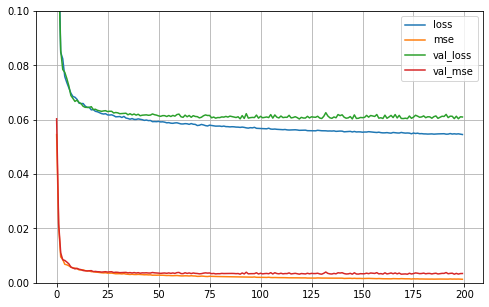

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.show()

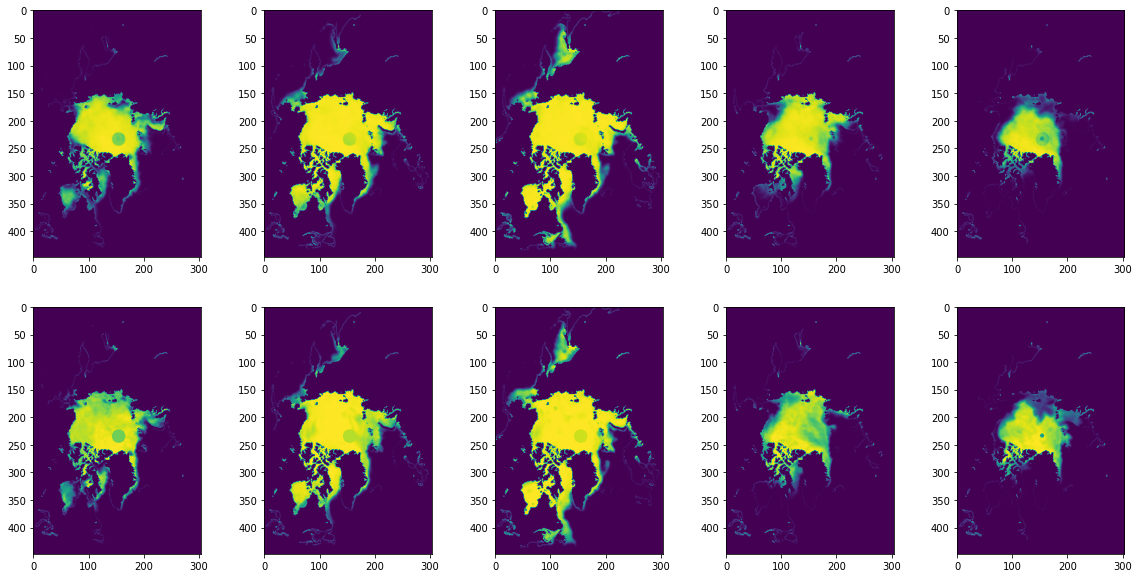

In [ ]:
fig = plot_predictions(model)
fig.show()

#### lr = 0.001, momentum = 0.999

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(512, return_sequences=True, input_shape=[None, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(512),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="selu"),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_28 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_53 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_29 (Batc (None, 512)               2048      
_________________________________________________________________
dense_40 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_41 (Dense)             (None, 256)               65792     
Total params: 3,875,328
Trainable params: 3,873,280
Non-trainable params: 2,048
_______________________________________

In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_28 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_53 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_29 (Batc (None, 512)               2048      
_________________________________________________________________
dense_40 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_41 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_decoder (Dense)        multiple                

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3, momentum=0.999),
                metrics=["mse"])

history = model.fit(X_train, Y_train_raw, epochs=400, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/400
40/40 [==============================] - 4s 39ms/step - loss: 0.3266 - mse: 0.0728 - val_loss: 0.3297 - val_mse: 0.0784
Epoch 2/400
40/40 [==============================] - 1s 19ms/step - loss: 0.2564 - mse: 0.0537 - val_loss: 0.2761 - val_mse: 0.0684
Epoch 3/400
40/40 [==============================] - 1s 17ms/step - loss: 0.2016 - mse: 0.0385 - val_loss: 0.2065 - val_mse: 0.0510
Epoch 4/400
40/40 [==============================] - 1s 18ms/step - loss: 0.1625 - mse: 0.0288 - val_loss: 0.1497 - val_mse: 0.0329
Epoch 5/400
40/40 [==============================] - 1s 18ms/step - loss: 0.1300 - mse: 0.0215 - val_loss: 0.1182 - val_mse: 0.0209
Epoch 6/400
40/40 [==============================] - 1s 17ms/step - loss: 0.1104 - mse: 0.0169 - val_loss: 0.1014 - val_mse: 0.0152
Epoch 7/400
40/40 [==============================] - 1s 17ms/step - loss: 0.1002 - mse: 0.0148 - val_loss: 0.0897 - val_mse: 0.0118
Epoch 8/400
40/40 [==============================] - 1s 18ms/step - loss: 0.

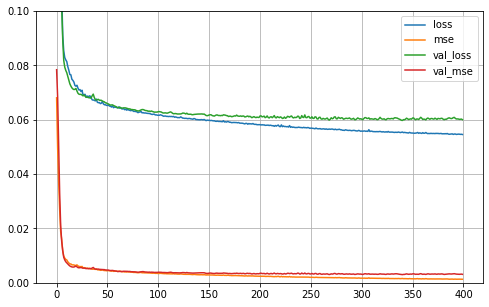

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.show()

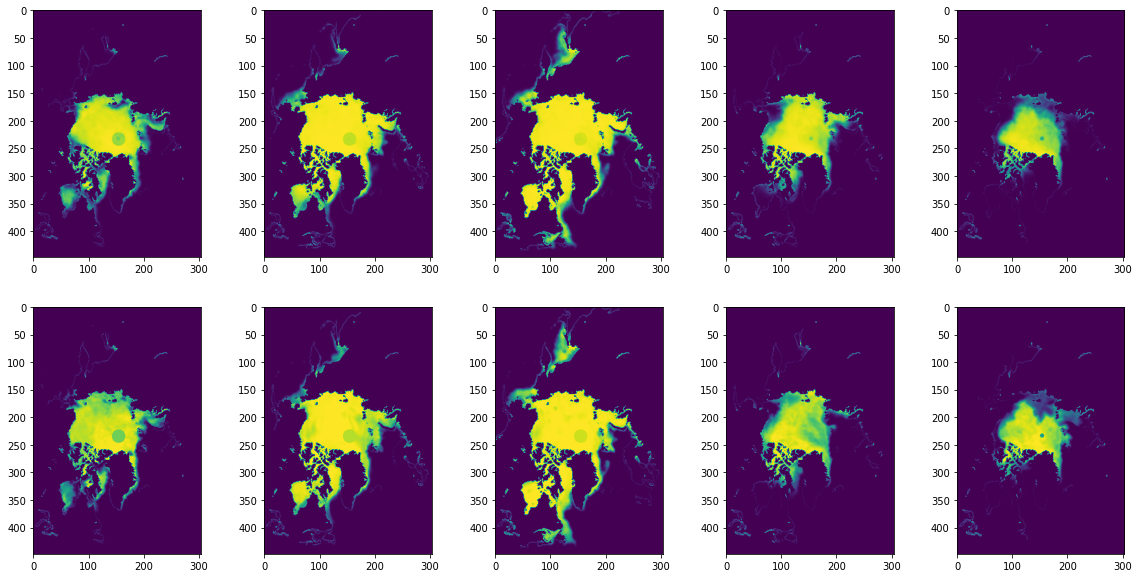

In [ ]:
fig = plot_predictions(model)
fig.show()

#### lr = 0.001, momentum = 0.999 with l2 regularization

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(512, return_sequences=True, input_shape=[None, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(512),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="selu",
                        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(256, activation="sigmoid",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])

model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_32 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_57 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_33 (Batc (None, 512)               2048      
_________________________________________________________________
dense_44 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_45 (Dense)             (None, 256)               65792     
Total params: 3,875,328
Trainable params: 3,873,280
Non-trainable params: 2,048
_______________________________________

In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_32 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_57 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_33 (Batc (None, 512)               2048      
_________________________________________________________________
dense_44 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_45 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_decoder (Dense)        multiple                

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3, momentum=0.999),
                metrics=["mse"])

history = model.fit(X_train, Y_train_raw, epochs=400, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/400
40/40 [==============================] - 4s 38ms/step - loss: 6.2721 - mse: 0.0715 - val_loss: 6.1211 - val_mse: 0.0794
Epoch 2/400
40/40 [==============================] - 1s 17ms/step - loss: 5.9259 - mse: 0.0532 - val_loss: 5.5439 - val_mse: 0.0706
Epoch 3/400
40/40 [==============================] - 1s 18ms/step - loss: 5.2797 - mse: 0.0415 - val_loss: 4.7031 - val_mse: 0.0586
Epoch 4/400
40/40 [==============================] - 1s 18ms/step - loss: 4.4032 - mse: 0.0310 - val_loss: 3.7062 - val_mse: 0.0433
Epoch 5/400
40/40 [==============================] - 1s 17ms/step - loss: 3.4077 - mse: 0.0212 - val_loss: 2.6758 - val_mse: 0.0257
Epoch 6/400
40/40 [==============================] - 1s 17ms/step - loss: 2.4173 - mse: 0.0158 - val_loss: 1.7393 - val_mse: 0.0160
Epoch 7/400
40/40 [==============================] - 1s 18ms/step - loss: 1.5285 - mse: 0.0127 - val_loss: 0.9798 - val_mse: 0.0120
Epoch 8/400
40/40 [==============================] - 1s 17ms/step - loss: 0.

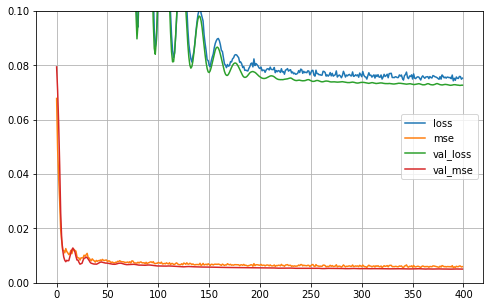

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.show()

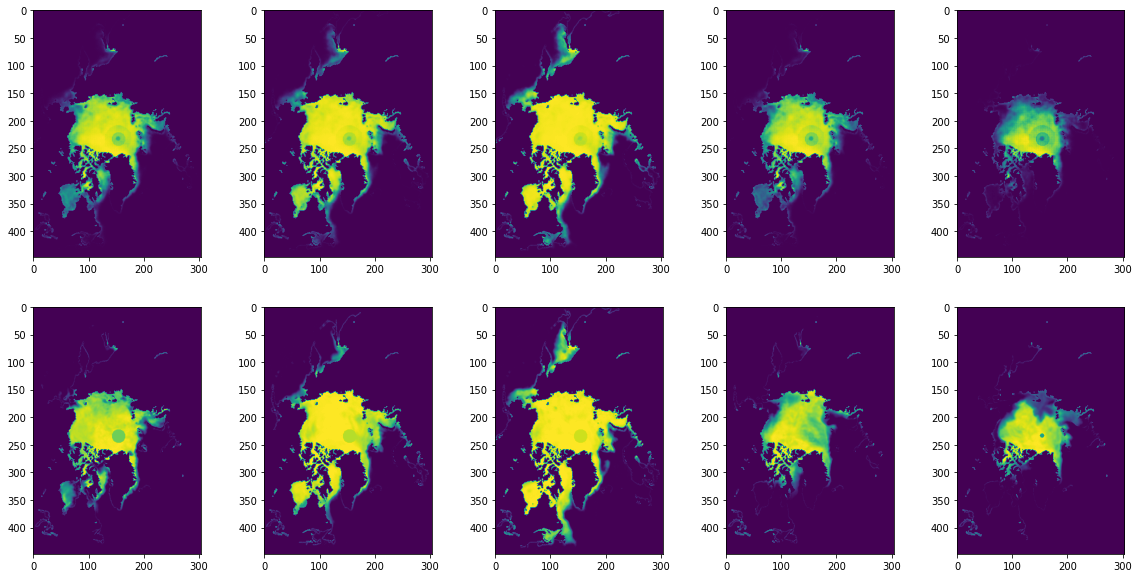

In [ ]:
fig = plot_predictions(model)
fig.show()

#### lr = 0.001, momentum = 0.999 with dropout

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(512, return_sequences=True, input_shape=[None, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(512),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="selu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(256, activation="sigmoid")
])

model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_34 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_59 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_35 (Batc (None, 512)               2048      
_________________________________________________________________
dense_46 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)             

In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_34 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_59 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_35 (Batc (None, 512)               2048      
_________________________________________________________________
dense_46 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)             

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3, momentum=0.999),
                metrics=["mse"])

history = model.fit(X_train, Y_train_raw, epochs=400, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/400
40/40 [==============================] - 4s 38ms/step - loss: 0.3399 - mse: 0.0751 - val_loss: 0.3321 - val_mse: 0.0791
Epoch 2/400
40/40 [==============================] - 1s 17ms/step - loss: 0.2594 - mse: 0.0537 - val_loss: 0.2797 - val_mse: 0.0693
Epoch 3/400
40/40 [==============================] - 1s 18ms/step - loss: 0.2041 - mse: 0.0394 - val_loss: 0.2132 - val_mse: 0.0529
Epoch 4/400
40/40 [==============================] - 1s 17ms/step - loss: 0.1738 - mse: 0.0333 - val_loss: 0.1498 - val_mse: 0.0326
Epoch 5/400
40/40 [==============================] - 1s 17ms/step - loss: 0.1420 - mse: 0.0248 - val_loss: 0.1185 - val_mse: 0.0203
Epoch 6/400
40/40 [==============================] - 1s 17ms/step - loss: 0.1065 - mse: 0.0151 - val_loss: 0.1073 - val_mse: 0.0165
Epoch 7/400
40/40 [==============================] - 1s 17ms/step - loss: 0.1032 - mse: 0.0147 - val_loss: 0.0969 - val_mse: 0.0138
Epoch 8/400
40/40 [==============================] - 1s 17ms/step - loss: 0.

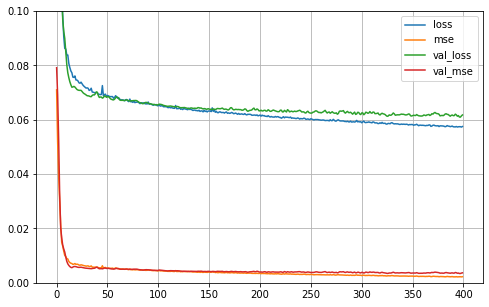

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.show()

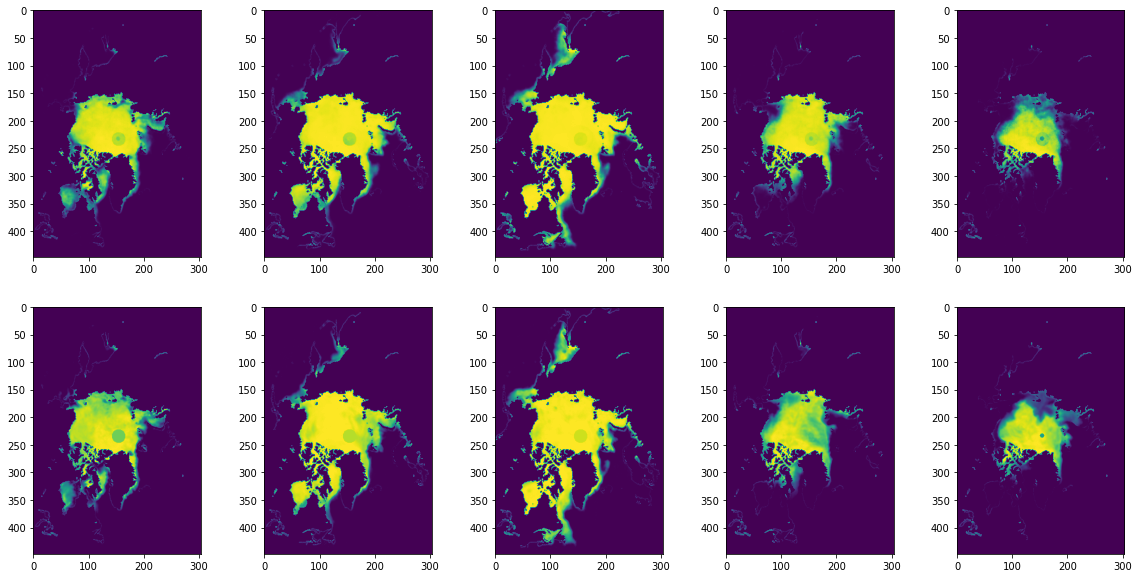

In [ ]:
fig = plot_predictions(model)
fig.show()

#### lr = 0.001, momentum = 0.999 with max norm

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(512, return_sequences=True, input_shape=[None, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(512),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="selu",
                       kernel_constraint=keras.constraints.max_norm(1.0),
                       #kernel_regularizer=keras.regularizers.l2(0.005)
                       ),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(256, activation="sigmoid",
                       kernel_constraint=keras.constraints.max_norm(0.5), 
                       #kernel_regularizer=keras.regularizers.l2(0.005)
                       )
])

model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_104 (LSTM)              (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_80 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_105 (LSTM)              (None, 512)               2099200   
_________________________________________________________________
batch_normalization_81 (Batc (None, 512)               2048      
_________________________________________________________________
dense_89 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 256)             

In [ ]:
for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_104 (LSTM)              (None, None, 512)         1574912   
_________________________________________________________________
batch_normalization_80 (Batc (None, None, 512)         2048      
_________________________________________________________________
lstm_105 (LSTM)              (None, 512)               2099200   
_________________________________________________________________
batch_normalization_81 (Batc (None, 512)               2048      
_________________________________________________________________
dense_89 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 256)             

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3, momentum=0.999),
                metrics=["mse"])

history = model.fit(X_train, Y_train_raw, epochs=400, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/400
40/40 [==============================] - 5s 37ms/step - loss: 0.3237 - mse: 0.0737 - val_loss: 0.3467 - val_mse: 0.0814
Epoch 2/400
40/40 [==============================] - 1s 17ms/step - loss: 0.2851 - mse: 0.0632 - val_loss: 0.3170 - val_mse: 0.0764
Epoch 3/400
40/40 [==============================] - 1s 17ms/step - loss: 0.2445 - mse: 0.0471 - val_loss: 0.2524 - val_mse: 0.0628
Epoch 4/400
40/40 [==============================] - 1s 17ms/step - loss: 0.1896 - mse: 0.0354 - val_loss: 0.1749 - val_mse: 0.0417
Epoch 5/400
40/40 [==============================] - 1s 17ms/step - loss: 0.1696 - mse: 0.0330 - val_loss: 0.1285 - val_mse: 0.0255
Epoch 6/400
40/40 [==============================] - 1s 17ms/step - loss: 0.1178 - mse: 0.0193 - val_loss: 0.1086 - val_mse: 0.0172
Epoch 7/400
40/40 [==============================] - 1s 17ms/step - loss: 0.0975 - mse: 0.0137 - val_loss: 0.0990 - val_mse: 0.0145
Epoch 8/400
40/40 [==============================] - 1s 17ms/step - loss: 0.

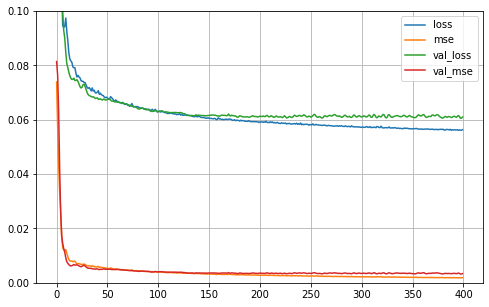

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.show()

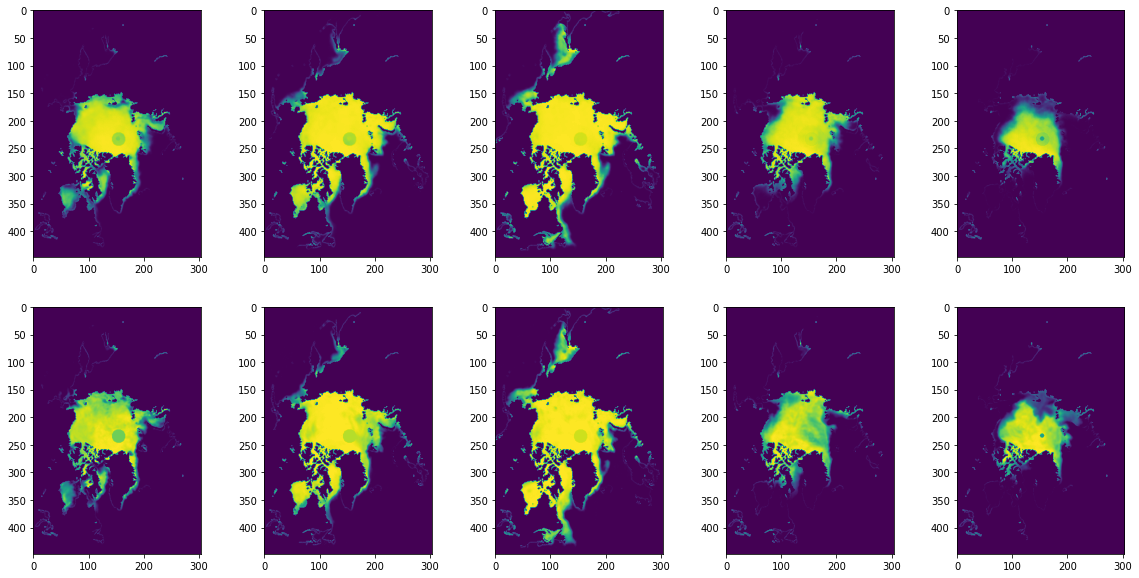

In [ ]:
fig = plot_predictions(model)
fig.show()

### **Prediction Model with Multi Head Attention**



From the famous paper "all you need is Attention", I wanted to try out the multi-head self-attention inside this model and see how it works

so tried two models

1. (BatchNorm => Multi Head self-Attention(8 heads) => BatchNorm => Dense(256)) * 4  
  **Validation Loss after 100 epochs:** 0.0620 

2. (BatchNorm => Multi Head self-Attention(8 heads) => BatchNorm => Dense(256)) * 8 with skip layers  
  **Validation Loss after 100 epochs:** 0.0611

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=50):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return (tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)) / 5

In [ ]:
learning_rate = CustomSchedule(512)

Text(0.5, 0, 'Train Step')

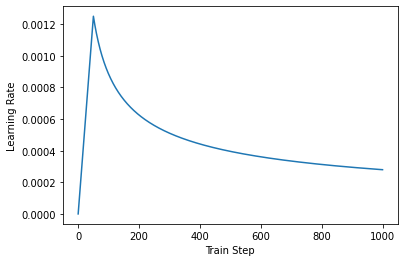

In [ ]:
temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(1000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### MultiHead Attention Model with 4 loops

In [ ]:
input = tf.keras.Input(shape=[5, 256])

x = tf.keras.layers.BatchNormalization()(input)
x = tf.keras.layers.MultiHeadAttention(8, 512)(x, x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)

for i in range(3):
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MultiHeadAttention(8, 512)(x, x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(256, activation="relu")(x)

x = tf.keras.layers.Reshape(target_shape=[-1,])(x)
output = tf.keras.layers.Dense(256, activation="sigmoid")(x)

model_mth = keras.Model(inputs=input, outputs=output)

model_mth.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 5, 256)]     0                                            
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 5, 256)       1024        input_30[0][0]                   
__________________________________________________________________________________________________
multi_head_attention_40 (MultiH (None, 5, 256)       4206848     batch_normalization_54[0][0]     
                                                                 batch_normalization_54[0][0]     
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 5, 256)       1024        multi_head_attention_40[0]

In [ ]:
model = keras.models.Sequential()
model.add(model_mth)

for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_20 (Functional)        (None, 256)               17426688  
_________________________________________________________________
dense_9 (Dense)              (None, 272384)            70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_14 (Reshape)         (None, 448, 304)          0         
Total params: 87,434,145
Trainable params: 17,422,592
Non-trainable params: 70,011,553
________________________________

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=["mse"])

history = model.fit(X_train, Y_train_raw, epochs=100, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/100
40/40 [==============================] - 6s 73ms/step - loss: 0.1249 - mse: 0.0211 - val_loss: 0.1824 - val_mse: 0.0325
Epoch 2/100
40/40 [==============================] - 2s 55ms/step - loss: 0.0739 - mse: 0.0069 - val_loss: 0.0991 - val_mse: 0.0142
Epoch 3/100
40/40 [==============================] - 2s 55ms/step - loss: 0.0699 - mse: 0.0057 - val_loss: 0.0827 - val_mse: 0.0103
Epoch 4/100
40/40 [==============================] - 2s 56ms/step - loss: 0.0695 - mse: 0.0059 - val_loss: 0.0667 - val_mse: 0.0051
Epoch 5/100
40/40 [==============================] - 2s 55ms/step - loss: 0.0672 - mse: 0.0052 - val_loss: 0.0672 - val_mse: 0.0054
Epoch 6/100
40/40 [==============================] - 2s 55ms/step - loss: 0.0671 - mse: 0.0052 - val_loss: 0.0728 - val_mse: 0.0070
Epoch 7/100
40/40 [==============================] - 2s 55ms/step - loss: 0.0660 - mse: 0.0049 - val_loss: 0.0645 - val_mse: 0.0045
Epoch 8/100
40/40 [==============================] - 2s 55ms/step - loss: 0.

### Multi Head Attention model with skip layers with 8 loops 


In [ ]:
input = tf.keras.Input(shape=[5, 256])

x_1 = tf.keras.layers.BatchNormalization()(input)
x_2 = tf.keras.layers.MultiHeadAttention(8, 256)(x_1, x_1)
x_2_2 = x_2 + input
x_3 = tf.keras.layers.BatchNormalization()(x_2_2)
x_4 = tf.keras.layers.Dense(256, activation="relu")(x_3)

for i in range(7):
  x_1_1 = x_4 + x_2_2
  x_1 = tf.keras.layers.BatchNormalization()(x_1_1)
  x_2 = tf.keras.layers.MultiHeadAttention(8, 256)(x_1, x_1)
  x_2_2 = x_2 + x_1_1
  x_3 = tf.keras.layers.BatchNormalization()(x_2_2)
  x_4 = tf.keras.layers.Dense(256, activation="relu")(x_3)

x = tf.keras.layers.Reshape(target_shape=[-1,])(x_4)
output = tf.keras.layers.Dense(256, activation="sigmoid")(x)

model_mth = keras.Model(inputs=input, outputs=output)

model_mth.summary()

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 5, 256)]     0                                            
__________________________________________________________________________________________________
batch_normalization_238 (BatchN (None, 5, 256)       1024        input_49[0][0]                   
__________________________________________________________________________________________________
multi_head_attention_132 (Multi (None, 5, 256)       2103552     batch_normalization_238[0][0]    
                                                                 batch_normalization_238[0][0]    
__________________________________________________________________________________________________
tf.__operators__.add_158 (TFOpL (None, 5, 256)       0           multi_head_attention_132[0

In [ ]:
model = keras.models.Sequential()
model.add(model_mth)

for i in range(len(decoder.layers)):
  model.add(decoder.layers[i])

for layer in model.layers[-5:]:
  layer.trainable = False

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_38 (Functional)        (None, 256)               17699072  
_________________________________________________________________
dense_9 (Dense)              (None, 272384)            70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_14 (Reshape)         (None, 448, 304)          0         
Total params: 87,706,529
Trainable params: 17,690,880
Non-trainable params: 70,015,649
________________________________

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.001, momentum=0.999),
                metrics=["mse"])

history = model.fit(X_train, Y_train_raw, epochs=500, batch_size = 10, shuffle=True, validation_data=(X_valid, Y_valid_raw))

Epoch 1/500
40/40 [==============================] - 9s 89ms/step - loss: 0.3100 - mse: 0.0709 - val_loss: 0.1407 - val_mse: 0.0287
Epoch 2/500
40/40 [==============================] - 2s 62ms/step - loss: 0.1435 - mse: 0.0295 - val_loss: 0.1045 - val_mse: 0.0171
Epoch 3/500
40/40 [==============================] - 2s 61ms/step - loss: 0.0909 - mse: 0.0131 - val_loss: 0.0971 - val_mse: 0.0148
Epoch 4/500
40/40 [==============================] - 2s 61ms/step - loss: 0.0980 - mse: 0.0142 - val_loss: 0.0984 - val_mse: 0.0143
Epoch 5/500
40/40 [==============================] - 2s 61ms/step - loss: 0.0923 - mse: 0.0125 - val_loss: 0.0887 - val_mse: 0.0110
Epoch 6/500
40/40 [==============================] - 2s 61ms/step - loss: 0.0839 - mse: 0.0097 - val_loss: 0.0817 - val_mse: 0.0089
Epoch 7/500
40/40 [==============================] - 2s 61ms/step - loss: 0.0794 - mse: 0.0083 - val_loss: 0.0783 - val_mse: 0.0078
Epoch 8/500
40/40 [==============================] - 2s 62ms/step - loss: 0.

### Submission

Use the model with 2 layer LSTM and Batch Normalization, learning rate=0.001, momentum=0.9999.  
Submission Score(MAE): 4.48. For pixel value ranging from 0 to 250

In [ ]:
K = keras.backend

def mae_score(true, pred):
    true = K.reshape(true, shape=(1, -1))
    pred = K.reshape(pred, shape=(1, -1))
    score = K.mean(K.abs(true-pred))
    
    return score

def f1_score(true, pred):

    true = K.reshape(true, shape=(1, -1))
    pred = K.reshape(pred, shape=(1, -1))

    true1 = K.cast(true > (250 * 0.05), 'float64')
    true2 = K.cast(true < (250 * 0.5), 'float64')
    true3 = K.cast(true > (250 * 0.15), 'float64')

    pred1 = K.cast(pred > (250 * 0.05), 'float64')
    pred2 = K.cast(pred < (250 * 0.5), 'float64')
    pred3 = K.cast(pred > (250 * 0.15), 'float64')

    true = true1 * true2 * true3
    pred = pred1 * pred2 * pred3
    
    right_bool = (true * pred == 1)

    right = K.sum(K.cast(right_bool, 'float64'))
    precision = right / K.sum(true+1e-8)
    recall = right / K.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score
    
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1+1e-8)
    
    return score

In [ ]:
x = np.array([1,2,3]).reshape(-1)
x.shape

(3,)

In [ ]:
X_test.shape

(12, 5, 256)

In [ ]:
y_pred = model.predict(X_test)

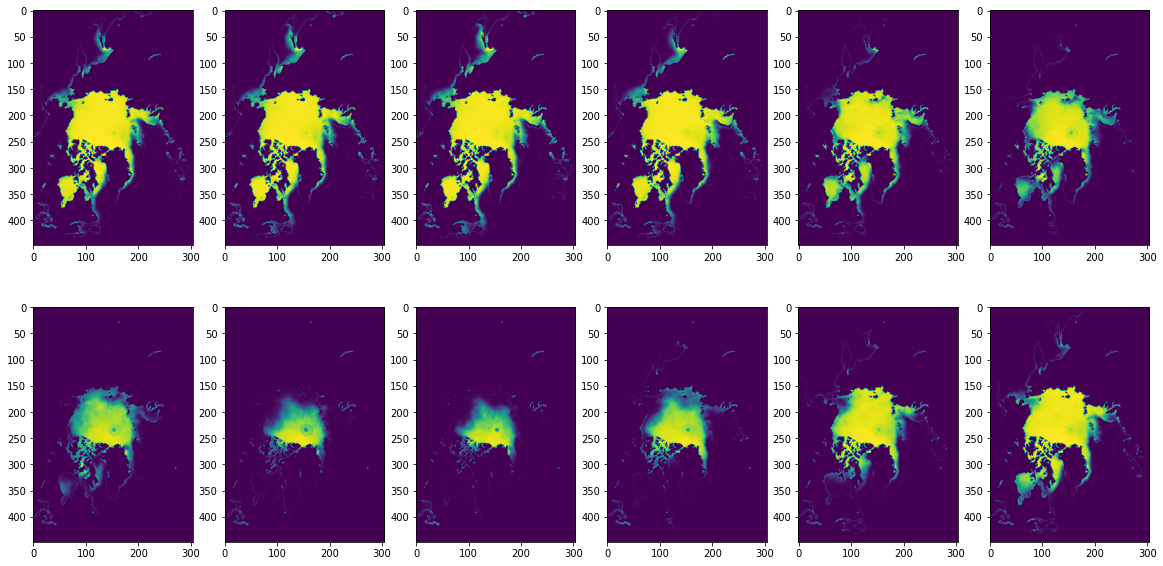

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i in range(12):
  fig.add_subplot(2, 6, i+1)
  plt.imshow(y_pred[i])
fig.show()

In [ ]:
sample_submission_df = pd.read_csv("sample_submission.csv")
sample_submission_df.head()

month  0  1  2  3  4  ...  136186  136187  136188  136189  136190  136191
0  2019-01  0  0  0  0  0  ...       0       0       0       0       0       0
1  2019-02  0  0  0  0  0  ...       0       0       0       0       0       0
2  2019-03  0  0  0  0  0  ...       0       0       0       0       0       0
3  2019-04  0  0  0  0  0  ...       0       0       0       0       0       0
4  2019-05  0  0  0  0  0  ...       0       0       0       0       0       0

[5 rows x 136193 columns]

In [ ]:
x = pd.DataFrame(data=y_pred[0].reshape(1, -1)*250)
y = pd.DataFrame(data=y_pred[1].reshape(1, -1)*250)

In [ ]:
pd.concat([x, y], axis=0)

0         1         2       ...    136189    136190    136191
0  0.196027  0.004337  0.001517  ...  0.000024  0.000035  0.000046
0  0.196563  0.004382  0.001503  ...  0.000022  0.000032  0.000042

[2 rows x 136192 columns]

In [ ]:
y_preds_df = []

for i in range(12):
  month_df = pd.DataFrame(data=y_pred[i].reshape(1, -1)*250)

  y_preds_df.append(month_df)

In [ ]:
concat_df = pd.concat(y_preds_df, axis=0)

In [ ]:
concat_df['month'] = sample_submission_df['month'].values[:12]

In [ ]:
concat_df

0         1         2  ...    136190    136191    month
0  0.196027  0.004337  0.001517  ...  0.000035  0.000046  2019-01
0  0.196563  0.004382  0.001503  ...  0.000032  0.000042  2019-02
0  0.194206  0.004273  0.001452  ...  0.000030  0.000040  2019-03
0  0.193644  0.004208  0.001414  ...  0.000032  0.000042  2019-04
0  0.209069  0.004859  0.001738  ...  0.000051  0.000066  2019-05
0  0.223710  0.005584  0.002121  ...  0.000078  0.000097  2019-06
0  0.245688  0.006694  0.002647  ...  0.000122  0.000150  2019-07
0  0.285530  0.009101  0.003790  ...  0.000170  0.000200  2019-08
0  0.299328  0.010083  0.004291  ...  0.000178  0.000205  2019-09
0  0.264158  0.007778  0.003153  ...  0.000117  0.000138  2019-10
0  0.228480  0.005790  0.002144  ...  0.000080  0.000098  2019-11
0  0.206006  0.004684  0.001685  ...  0.000053  0.000068  2019-12

[12 rows x 136193 columns]

In [ ]:
df_month = sample_submission_df.iloc[:, 0]

In [ ]:
df_month

0     2019-01
1     2019-02
2     2019-03
3     2019-04
4     2019-05
5     2019-06
6     2019-07
7     2019-08
8     2019-09
9     2019-10
10    2019-11
11    2019-12
12    2020-01
13    2020-02
14    2020-03
15    2020-04
16    2020-05
17    2020-06
18    2020-07
19    2020-08
20    2020-09
21    2020-10
22    2020-11
23    2020-12
Name: month, dtype: object

In [ ]:
submission_df = pd.merge(df_month, concat_df, on="month", how="left")

In [ ]:
submission_df = submission_df.fillna(0)

In [ ]:
submission_df.to_csv("submission02.csv", index=False)

In [ ]:
pd.read_csv("submission02.csv")

month         0         1  ...    136189    136190    136191
0   2019-01  0.196027  0.004337  ...  0.000024  0.000035  0.000046
1   2019-02  0.196563  0.004382  ...  0.000022  0.000032  0.000042
2   2019-03  0.194206  0.004273  ...  0.000021  0.000030  0.000040
3   2019-04  0.193644  0.004208  ...  0.000021  0.000032  0.000042
4   2019-05  0.209069  0.004859  ...  0.000030  0.000051  0.000066
5   2019-06  0.223710  0.005584  ...  0.000043  0.000078  0.000097
6   2019-07  0.245688  0.006694  ...  0.000068  0.000122  0.000150
7   2019-08  0.285530  0.009101  ...  0.000107  0.000170  0.000200
8   2019-09  0.299328  0.010083  ...  0.000121  0.000178  0.000205
9   2019-10  0.264158  0.007778  ...  0.000083  0.000117  0.000138
10  2019-11  0.228480  0.005790  ...  0.000053  0.000080  0.000098
11  2019-12  0.206006  0.004684  ...  0.000035  0.000053  0.000068
12  2020-01  0.000000  0.000000  ...  0.000000  0.000000  0.000000
13  2020-02  0.000000  0.000000  ...  0.000000  0.000000  0.000000
14  2020-03  0.000000  0.000000  ...  0.000000  0.000000  0.000000
15  2020-04  0.000000  0.000000  ...  0.000000  0.000000  0.000000
16  2020-05  0.000000  0.000000  ...  0.000000  0.000000  0.000000
17  2020-06  0.000000  0.000000  ...  0.000000  0.000000  0.000000
18  2020-07  0.000000  0.000000  ...  0.000000  0.000000  0.000000
19  2020-08  0.000000  0.000000  ...  0.000000  0.000000  0.000000
20  2020-09  0.000000  0.000000  ...  0.000000  0.000000  0.000000
21  2020-10  0.000000  0.000000  ...  0.000000  0.000000  0.000000
22  2020-11  0.000000  0.000000  ...  0.000000  0.000000  0.000000
23  2020-12  0.000000  0.000000  ...  0.000000  0.000000  0.000000

[24 rows x 136193 columns]